Central questions: can classifiers be trained using neuroimaging meta-analysis data (i.e., coordinates, modeled activation maps, etc.). 
Goals: [1] train classifier using coordinates/modeled activation maps, [2]...

In [1]:
# Import libraries and packages.
import pandas as pd
import numpy as np
import glob
import datetime; today = datetime.date.today()
from nimare.io import convert_sleuth_to_dataset
from nimare.meta.cbma.kernel import ALEKernel
import neurosynth as ns
from neurosynth.base.dataset import Dataset
from functools import reduce

In [2]:
# lets now work with full neurosynth data instead of meta analysis maps
# ns.dataset.download(path='neurosynth/', unpack=True)
dataset = Dataset('neurosynth/database.txt')
dataset.add_features('neurosynth/features.txt')
# get ids for the four different classes
ids_saccades = dataset.get_studies(features='saccades', frequency_threshold=0.001)
ids_tmind = dataset.get_studies(features='theory mind', frequency_threshold=0.001)
ids_pain = dataset.get_studies(features='pain', frequency_threshold=0.001)
ids_counting = dataset.get_studies(features='calculation*', frequency_threshold=0.001)

/Users/Bharath/anaconda3/envs/py37/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/Users/Bharath/anaconda3/envs/py37/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()
/Users/Bharath/anaconda3/envs/py37/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/Bharath/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:808: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc

In [3]:
# get the neurosynth data for each of these conditions
ids = list([ids_saccades, ids_tmind, ids_pain, ids_counting])
neurosynth_dataframes = {}
k = 0
for id in np.arange(0, len(ids)):
    this_img_data = dataset.get_image_data(ids[id])
    data_array = dataset.masker.unmask(this_img_data)
    if data_array.size > 0:
        this_img_array = []
        for i in np.arange(0, data_array.shape[-1]):
            this_img_array.append((np.ravel(data_array[:,:,:,i], order='C').T))
        neurosynth_dataframes[k] = pd.DataFrame(this_img_array)
        neurosynth_dataframes[k]['y'] = id
        k = k + 1

neurosynth_data = pd.concat([neurosynth_dataframes[0], neurosynth_dataframes[1]], ignore_index=True)
for i in np.arange(2, k):
    neurosynth_data = pd.concat([neurosynth_data, neurosynth_dataframes[i]], ignore_index=True)
neurosynth_data

,0,1,2,3,4,5,6,7,8,9,...,902620,902621,902622,902623,902624,902625,902626,902627,902628,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
unique_classes = np.unique(neurosynth_data['y'])
# now we include all classes for training, but this can be modified to include a subset of classes
train_classes = unique_classes

In [5]:
data_train_neurosynth = neurosynth_data.loc[neurosynth_data['y'].isin(train_classes)].reset_index(drop=True)

In [6]:
# remove voxels which are zero in all classes in the training set
zero_voxels = (data_train_neurosynth != 0).any(axis=0).values
sub_sampled_data_train_neurosynth = data_train_neurosynth.loc[:, zero_voxels]
sub_sampled_data_train_neurosynth

,93491,93492,93493,93582,93583,93672,93673,93674,93764,102954,...,798110,798190,798191,798192,798193,798281,798282,798283,798373,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# Select directories and files structure.
input_prefix = str(today)
output_prefix = str(today)
in_dir = 'constructs'
# paths = glob.glob("constructs/*.txt")
paths=['constructs/saccades.txt',
      'constructs/tmind.txt',
      'constructs/pain.txt',
      'constructs/counting.txt']
print('constructs to model = {0}'.format(len(paths)))

constructs to model = 4


In [8]:
# Convert coordinates to nimare dataset. DOES NOT WORK!
datas = {}
for path in paths:
    print(path)
    datas[path[len(in_dir) + 1:-4]] = convert_sleuth_to_dataset(path)
datas.keys()  # Confirm construct keys.

constructs/saccades.txt
constructs/tmind.txt
constructs/pain.txt
constructs/counting.txt


dict_keys(['saccades', 'tmind', 'pain', 'counting'])

In [9]:
print('MA maps making...\t\t@{0}'.format(str(datetime.datetime.now())))
ma_maps_arrs = {}
for data in datas.keys():
    kern = ALEKernel()
    ma_maps = kern.transform(datas[data])  # Compute MA maps (len = ???)
    ma_maps_arrs[data] = []
    for i in np.arange(0, len(ma_maps)):
        ma_maps_arrs[data].append(np.ravel(ma_maps[i].get_data(), order='C'))
    labels = pd.DataFrame(index=datas[data].ids)
print('MA maps done!\t\t\t@{0}'.format(str(datetime.datetime.now())))

MA maps making...		@2019-08-09 00:04:45.357199
MA maps done!			@2019-08-09 00:05:02.953562


In [10]:
keys = list(datas.keys())
brainmap_dataframes = {}
key = {}
for i in np.arange(0, len(keys)):
    key[keys[i]] = i
    arr = np.asarray(ma_maps_arrs[keys[i]])
    # rescale so that the maximum value in every row is 1, to match the scaling of neurosynth data
    transformed_arr = arr/arr.max(axis=1)[:,None]
    brainmap_dataframes[i] = pd.DataFrame(transformed_arr)
    brainmap_dataframes[i]['y'] = i

In [11]:
brainmap_data = pd.concat([brainmap_dataframes[0], brainmap_dataframes[1]], ignore_index=True)
for i in np.arange(2, len(keys)):
    brainmap_data = pd.concat([brainmap_data, brainmap_dataframes[i]], ignore_index=True)
brainmap_data

,0,1,2,3,4,5,6,7,8,9,...,902620,902621,902622,902623,902624,902625,902626,902627,902628,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
data_test_brainmap = brainmap_data.loc[brainmap_data['y'].isin(train_classes)].reset_index(drop=True)
# remove voxels which are zero in all classes in the training set
sub_sampled_data_test_brainmap = data_test_brainmap.loc[:, zero_voxels]
sub_sampled_data_test_brainmap

,93491,93492,93493,93582,93583,93672,93673,93674,93764,102954,...,798110,798190,798191,798192,798193,798281,798282,798283,798373,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.000061,0.000233,0.000725,0.000029,0.000113,0.000002,0.000012,0.000045,0.000004,6.736013e-05,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,6.882660e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
# use PCA to reduce dimensionality, take 100 principal components
from sklearn import decomposition
import matplotlib.pyplot as plt
pca = decomposition.PCA(n_components = 100)
y_train = sub_sampled_data_train_neurosynth.iloc[:,-1].values
y_test = sub_sampled_data_test_brainmap.iloc[:,-1].values
X_train_raw = sub_sampled_data_train_neurosynth.iloc[:,:-1].values
X_test_raw = sub_sampled_data_test_brainmap.iloc[:,:-1].values
pca.fit(X_train_raw)
# transform both training and test datasets
X_train = pca.transform(X_train_raw)
X_test = pca.transform(X_test_raw)

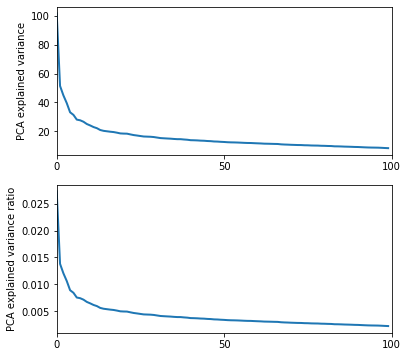

In [14]:
# plot the variance explained by principal components
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(6, 6))
ax0.plot(pca.explained_variance_, linewidth=2)
ax0.set_ylabel('PCA explained variance')
ax0.set_xticks(np.arange(0, 101, 50))
ax0.set_xlim([0,100])

ax1.plot(pca.explained_variance_ratio_, linewidth=2)
ax1.set_ylabel('PCA explained variance ratio')
ax1.set_xticks(np.arange(0, 101, 50))
ax1.set_xlim([0,100])
plt.show()

In [15]:
# fit two classifiers just for fun
from sklearn import svm
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
# check whether the classifiers do a decent job before training

# Linear SVM classifier
clf_svc = svm.LinearSVC(max_iter = 1000000, class_weight = 'balanced')
scores_svc = cross_val_score(clf_svc, X_train, y_train, cv=10)
print("Crossvalidated accuracy with Linear SVM classifier on Neurosynth data: %0.2f (+/- %0.2f) \n" % (scores_svc.mean(), scores_svc.std() * 2))

# Ridge classifier
clf_ridge = RidgeClassifier(alpha=100, class_weight = 'balanced')
scores_ridge = cross_val_score(clf_ridge, X_train, y_train, cv=10)
print("Crossvalidated accuracy with Ridge classifier on Neurosynth data: %0.2f (+/- %0.2f) \n" % (scores_ridge.mean(), scores_ridge.std() * 2))

# you can inspect the scores of individual classifiers by typing scores_svc, or scores_ridge

Crossvalidated accuracy with Linear SVM classifier on Neurosynth data: 0.66 (+/- 0.12) 

Crossvalidated accuracy with Ridge classifier on Neurosynth data: 0.66 (+/- 0.16) 



In [17]:
# use the above classifiers to predict classes of brainmap data

# Linear SVM classifier
clf_svc = svm.LinearSVC(max_iter = 1000000, class_weight = 'balanced')
clf_svc.fit(X_train, y_train)
y_predict_svc = clf_svc.predict(X_test)
svc_accuracy = len(np.where(y_test == y_predict_svc)[0])/len(y_test)
print("Accuracy of SVC classifier on Brainmap data: %0.2f \n" % (svc_accuracy))

# Ridge classifier
clf_ridge = RidgeClassifier(alpha=100, class_weight = 'balanced')
clf_ridge.fit(X_train, y_train)
y_predict_ridge = clf_ridge.predict(X_test)
ridge_accuracy = len(np.where(y_test == y_predict_ridge)[0])/len(y_test)
print("Accuracy of Ridge classifier on Brainmap data: %0.2f \n" % (ridge_accuracy))

Accuracy of SVC classifier on Brainmap data: 0.62 

Accuracy of Ridge classifier on Brainmap data: 0.60 

